In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df = pd.read_csv('../../data/Accidentes_2013_2023.csv')
df

,año,fall_les,tipo_veh,modelo_veh,g_modelo_veh,marca,color,hora_ocu_fall,g_hora_fall,g_hora_5_fall,día_sem_ocu_fall,mes_ocu_fall,causa_acc
0,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
1,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
2,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
3,2013,Fallecido,Motocicleta,2010-2019,ignorado,Great Wall,Rojo,Ignorado,00:00 a 05:59,ignorado,Martes,Enero,Choque
4,2013,Lesionado,Motocicleta,2010-2019,ignorado,Great Wall,Rojo,Ignorado,00:00 a 05:59,ignorado,Martes,Enero,Choque
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99510,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99511,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99512,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99513,2020,Fallecido,Motocicleta,2019,2010-2019,MRT,Rojo,18,18:00 a 23:59,Noche,Jueves,Diciembre,Atropello


# Exploracion de datos

In [2]:
# Mostrar cantidad de valores faltantes por columna
missing_values = df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

# Ver la distribución de clases en la variable objetivo
fall_les_distribution = df['fall_les'].value_counts(dropna=False)
print("\nDistribución de clases en 'fall_les':\n", fall_les_distribution)

Valores faltantes por columna:
 año                     0
fall_les            22566
tipo_veh                0
modelo_veh              0
 g_modelo_veh           0
marca                   0
color                   0
hora_ocu_fall           0
g_hora_fall             0
g_hora_5_fall           0
día_sem_ocu_fall        0
mes_ocu_fall            0
causa_acc               0
dtype: int64

Distribución de clases en 'fall_les':
 fall_les
Lesionado    64038
NaN          22566
Fallecido    12911
Name: count, dtype: int64


# Limpieza de datos

In [3]:
# Reemplazar los NaN en 'fall_les' con la categoría 'Ignorado'
df['fall_les'] = df['fall_les'].fillna('Ignorado')

# Confirmar la nueva distribución de clases en la variable objetivo
fall_les_distribution = df['fall_les'].value_counts(dropna=False)
print("\nDistribución de clases en 'fall_les' después de la limpieza:\n", fall_les_distribution)


Distribución de clases en 'fall_les' después de la limpieza:
 fall_les
Lesionado    64038
Ignorado     22566
Fallecido    12911
Name: count, dtype: int64


# Visualizacion de datos

In [4]:
df.shape

(99515, 13)

In [5]:
df.columns

Index(['año', 'fall_les', 'tipo_veh', 'modelo_veh', ' g_modelo_veh', 'marca',
       'color', 'hora_ocu_fall', 'g_hora_fall', 'g_hora_5_fall',
       'día_sem_ocu_fall', 'mes_ocu_fall', 'causa_acc'],
      dtype='object')

In [6]:
df.groupby('fall_les').size()

fall_les
Fallecido    12911
Ignorado     22566
Lesionado    64038
dtype: int64

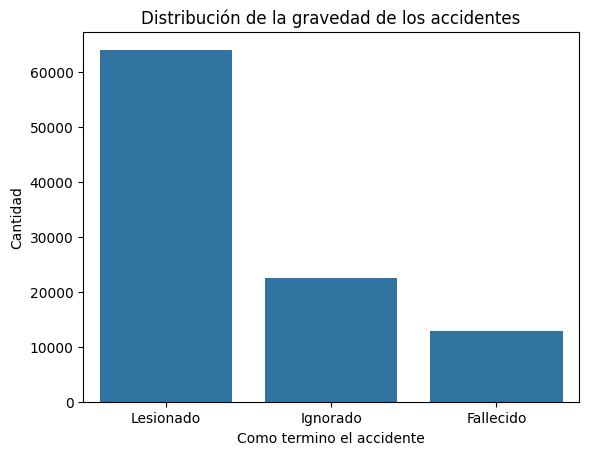

In [7]:
# Contar las ocurrencias de cada clase
conteo = df['fall_les'].value_counts().reset_index()
conteo.columns = ['Como termino el accidente', 'Cantidad']

# Graficar
sns.barplot(x='Como termino el accidente', y='Cantidad', data=conteo)
plt.xlabel("Como termino el accidente")
plt.ylabel("Cantidad")
plt.title("Distribución de la gravedad de los accidentes")
plt.show()

# Modelo SVM


## Modelo Lineal

In [8]:
# Separar X e y
X = df.drop(columns=['fall_les'])
y = df['fall_les']

# One-hot encoding de variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Codificar clase objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Entrenamiento con LinearSVC
modelo = LinearSVC(dual=False, max_iter=10000, random_state=42)
modelo.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=10000, random_state=42)

## Validacion Cruzada

In [9]:
# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(modelo, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [0.88866    0.88735367 0.8878561  0.88770537 0.8878561 ]
Promedio: 0.8878862483042758
Desviación estándar: 0.00042822239366252653


## Matriz de confusion

Accuracy: 0.8886953609110702
Reporte de clasificación:
               precision    recall  f1-score   support

   Fallecido       0.95      0.15      0.26      3873
    Ignorado       1.00      1.00      1.00      6770
   Lesionado       0.85      1.00      0.92     19212

    accuracy                           0.89     29855
   macro avg       0.94      0.72      0.73     29855
weighted avg       0.90      0.89      0.85     29855



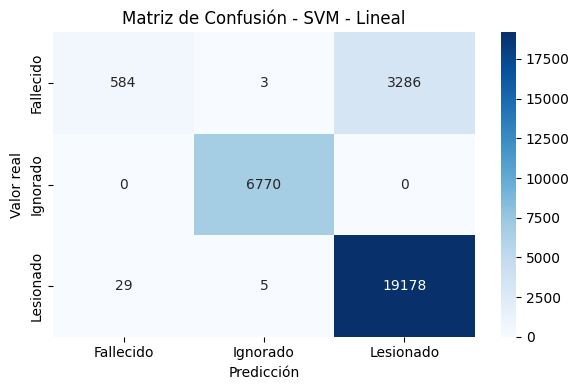

In [10]:
modelo.fit(X_train, y_train)

# Predicción y métricas
y_pred = modelo.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - SVM - Lineal")
plt.tight_layout()
plt.show()
